<a href="https://colab.research.google.com/github/ShivamAryaJha/InvoiceForm-Text-Extraction-via-PyTesseract/blob/main/Border_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 12 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,453 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
import numpy as np
import cv2
import imutils
from skimage.filters import threshold_local
import matplotlib.pyplot as plt
import string
import pytesseract
from pytesseract import Output
import PIL as Image
import os
from google.colab.patches import cv2_imshow
import csv

In [ ]:
def order_points(pts):
	rect = np.zeros((4, 2), dtype = "float32")
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	return rect

def four_point_transform(image, pts):
  rect = order_points(pts)
  (tl, tr, br, bl) = rect
  widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
  widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
  maxWidth = max(int(widthA), int(widthB))
  heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
  heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
  maxHeight = max(int(heightA), int(heightB))
  dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
  M = cv2.getPerspectiveTransform(rect, dst)
  warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
  return warped



In [ ]:
image = cv2.imread("/content/img1.jpeg")
ratio = image.shape[0] / 500.0
orig = image.copy()

edged = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret,edged = cv2.threshold(edged,20,255,cv2.THRESH_BINARY)
edged = cv2.GaussianBlur(edged, (5, 5), 0)
edged = cv2.Canny(edged, 75, 200)
T = threshold_local(edged, 11, offset = 10, method = "gaussian")
edged = (edged > T).astype("uint8") * 255

print("STEP 1: Edge Detection")
pr = 2*(image.shape[0] + image.shape[1])
print(pr)
cv2_imshow(edged)

cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

for c in cnts:
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)

#cv2_imshow( image)

        
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        print(peri)
        if  abs(cv2.arcLength(c, True) - pr) > 30 :
            screenCnt = approx
            break

cv2.drawContours(image, [screenCnt], -1, (255, 0, 0), 5) 
cv2_imshow(imutils.resize(image, height = 1000))


In [ ]:
 warped = four_point_transform(orig.copy(), screenCnt.reshape(4, 2) * ratio)
img =  imutils.resize(warped, height = 2000)
cv2_imshow(img)


[array([[[ 226,  137]],

       [[2373,  225]],

       [[2383, 3165]],

       [[ 134, 3293]]], dtype=int32)]
[1 2 3]


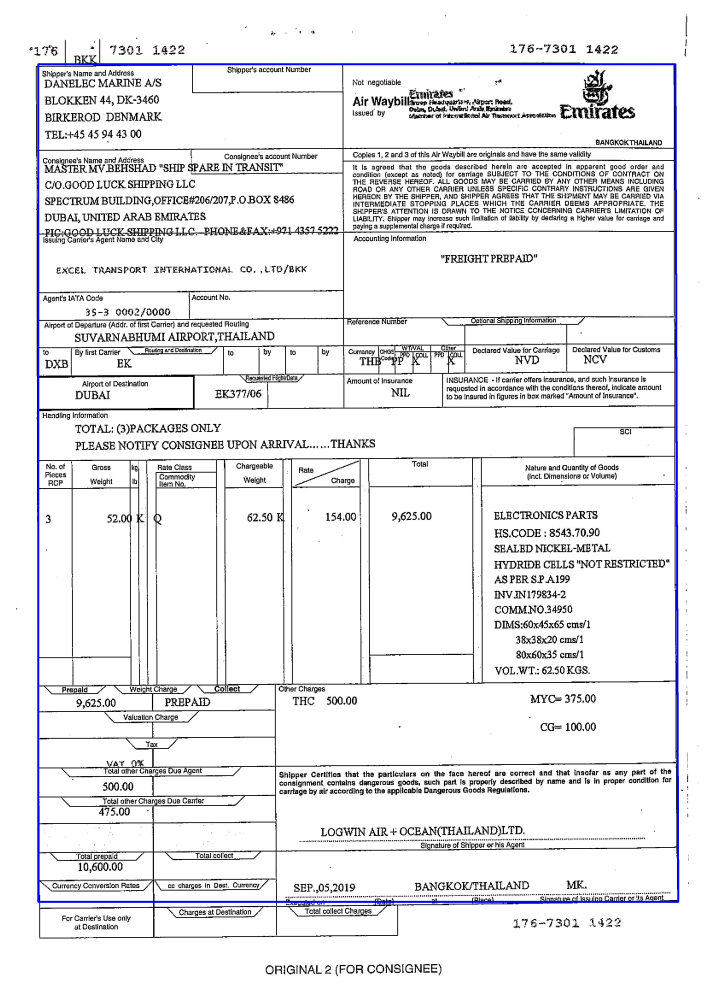

In [ ]:
orig = cv2.imread('/content/pdf2.jpg')
image = orig.copy()
ratio = image.shape[0] / 500.0
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret,image = cv2.threshold(image,210,255,cv2.THRESH_BINARY)
kernel = np.ones((7, 7))
image = cv2.erode(image, kernel, iterations=1) 
image = cv2.dilate(image, kernel, iterations=1)
image = cv2.GaussianBlur(image, (5, 5), 0)
image = cv2.Canny(image, 75, 200)
T = threshold_local(image, 11, offset = 10, method = "gaussian")
image = (image > T).astype("uint8") * 255

pr = 2*(image.shape[0] + image.shape[1])

cnts = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

timg = orig.copy()
for c in cnts:
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	cv2.drawContours(timg, [approx], -1, (0, 255, 0), 2)

#cv2_imshow(imutils.resize(timg, height = 1000))
        
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        if  abs(cv2.arcLength(c, True) - pr) > 100 :
            screenCnt = approx
            break

cv2.drawContours(timg, [screenCnt], -1, (255, 0, 0), 5) 

print([screenCnt])
#cv2_imshow(imutils.resize(timg, height = 1000))

pair = screenCnt[0]
save = 0
mn = np.sqrt(pair[0][0]**2 + pair[0][1]**2)
for i in range(4):
  pair = screenCnt[i]
  tmp = np.sqrt(pair[0][0]**2 + pair[0][1]**2)
  if mn > tmp:
    mn = tmp
    save = i

pts = {}
three = []
for i in range(4):
  if i != save:
    pair = screenCnt[i]
    tan = int(pair[0][1]/pair[0][0])
    pts[tan] = i
    three.append(tan)

three = np.array(three)
three = np.sort(three)

for i in range(3):
  three[i] =  pts[three[i]]
print(three)
pt = screenCnt[save]
pt[0][0] = screenCnt[three[2]] [0][0]
pt[0][1] = screenCnt[three[0]] [0][1]
#print(pt)

#f(screenCnt[abs(three[0]] [0][0] - screenCnt[abs(three[0]] [0][0] ))
screenCnt[save] = pt
screenCnt[three[2]] [0][1] =  screenCnt[three[1]] [0][1]
timg = orig.copy()
cv2.drawContours(timg, [screenCnt], -1, (255, 0, 0), 5) 
cv2_imshow(imutils.resize(timg, height = 1000))


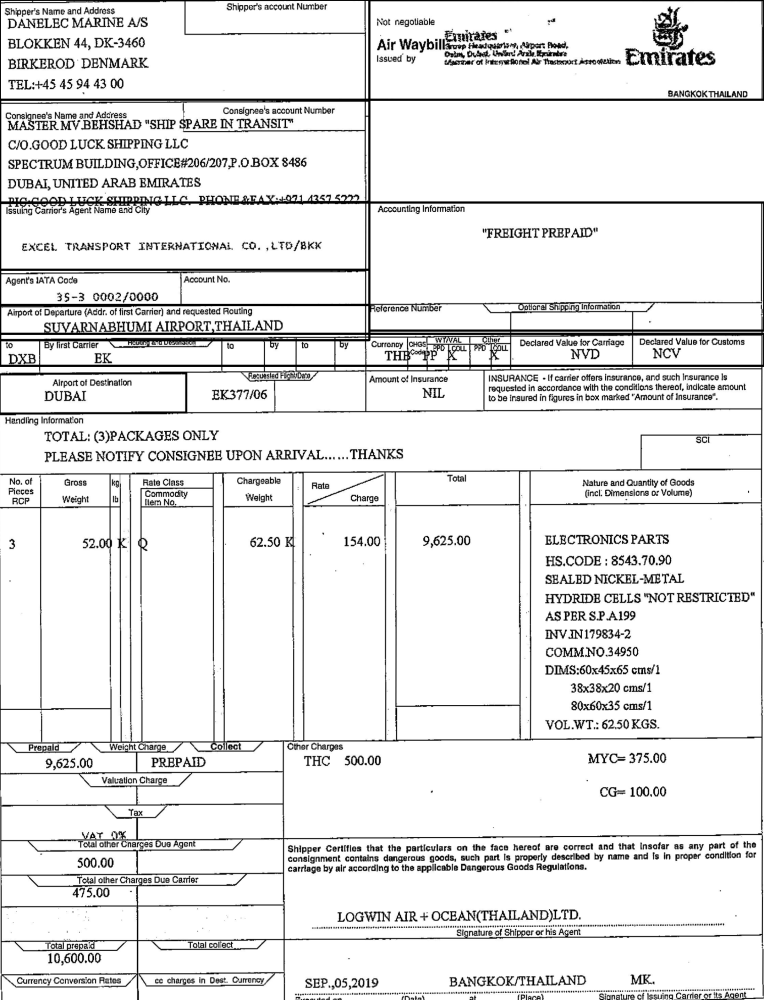

In [ ]:
warped = four_point_transform(orig.copy(), screenCnt.reshape(4, 2) )
img =  imutils.resize(warped, height = 3123)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

h, w = img.shape
img = cv2.rectangle(img, (w//2 - 40, w//7 - 30), (w, 2*w//7 - 50), (255, 255, 255), -1)

crops = []
crops.append(img[0 : w//7  - 30, 0 : w//2 - 40])
crops.append(img[0: w//7 - 30, w//2 - 40:w])
crops.append(img[w//7  - 30: 2*w//7 - 50,  0:w//2 - 40])
crops.append(img[2*w//7 - 50 : 2*w//7 + 160, 0 : w//2 - 40])
crops.append(img[2*w//7 + 160 :2*w//7 + 270, 0:  w//2 - 40])
crops.append(img[2*w//7 + 270 :2*w//7 + 380, 0 : w//2 - 40])
crops.append(img[2*w//7 -50 : 2*w//7 + 350, w//2 - 40 : w])
crops.append(img[2*w//7 + 360 : 2*w//7 + 460, 0 : w])

img = cv2.rectangle(img, (0, 0), (w//2 - 40, w//7 - 30), (0, 0, 0), 3)
img = cv2.rectangle(img, (w//2 - 40, 0), (w, w//7 - 30), (0, 0, 0), 5)
img = cv2.rectangle(img, (0, w//7  - 30), (w//2 - 40, 2*w//7 - 50), (0, 0, 0), 5)
img = cv2.rectangle(img, (0, 2*w//7 - 50), (w//2 - 40, 2*w//7 + 160), (0, 0, 0), 5)
img = cv2.rectangle(img, (0, 2*w//7 + 160), (w//2 - 40, 2*w//7 + 270), (0, 0, 0), 5)
img = cv2.rectangle(img, (0, 2*w//7 + 270), (w//2 - 40, 2*w//7 + 380), (0, 0, 0), 5)
img = cv2.rectangle(img, (w//2 - 40, 2*w//7 -50), (w, 2*w//7 + 350), (0, 0, 0), 5)
img = cv2.rectangle(img, (0, 2*w//7 + 360), (w, 2*w//7 + 460), (0, 0, 0), 5)

cv2_imshow( imutils.resize(img, height = 1000))

In [ ]:
text = []
str =  ""
for i in crops:
  str = pytesseract.image_to_string(i, config = '--oem 3 --psm 4')
  text.append(str)
  print(str)
  print("----------------------------------------------------------")

BLOKKEN 44, DK-3460
BIRKEROD DENMARK
TEL:+45 45 94 43 00

 

Shipper's Name and Address Shipper's account Number
DANELEC MARINE A/S

----------------------------------------------------------
Not negotiable *

Air Waybilleat ison sp Apes: Boge,

Issued by eee ot oration vl Air rucernoct Arwotelies Emirates

 

BANGKOK THAILAND

----------------------------------------------------------
MASTE R MV BE EHSHAD “SHIP SPARE IN TRANSIT"

C/0.GOOD LUCK SHIPPING LLC

SPECTRUM BUILDING, OFFICE #206/207,P.O BOX 8486
DUBAI, UNITED ARAB EMIRATES

 

----------------------------------------------------------
Issuing Carsiers Agent Name and Clty

EXCEL TRANSPORT INTERNATIONAL CO. ,LTO/BKK

 

----------------------------------------------------------
36-3 6002/0006

----------------------------------------------------------
 

SUVARNABHUMI AIRPORT, THAILAND |

----------------------------------------------------------
Accounting Information

“FREIGHT PREPAID"

 

Reference Number

------------

In [ ]:
new_text = []
special = [']', '[', '|', '=', '\\', '.', '-', '»','«', '!', '*', '~', '{', '}']
itr = 0
for block in text:
  flag = 0
  lines = block.splitlines()
  emp = ""
  for line in lines:
    flag = 0
    for j in line:
      if ord(j) >= 48:
        flag = 1
        break
    if flag == 0:
      continue

    words = line.split()
    #print(words)
    for w in words:
      flag = 1
      for k in w:
        if ord(k) >= 97 and ord(k) <= 122 and itr != 1:
          flag = 0
          break
      if flag == 1:
        emp = emp + " " + w
    emp = emp + "\n"
  #print(emp)
  new_text.append(emp)
  itr = itr+1  

In [ ]:
for x in new_text:
  for i in special:
    x = x.replace(i, '')
    x = x.replace("\n\n", "\n")
  print(x)
  print("----------------------------------------------------")

 BLOKKEN 44, DK3460
 BIRKEROD DENMARK
 TEL:+45 45 94 43 00
 DANELEC MARINE A/S

----------------------------------------------------
 Not negotiable 
 Air Waybilleat ison sp Apes: Boge,
 Issued by eee ot oration vl Air rucernoct Arwotelies Emirates
 BANGKOK THAILAND

----------------------------------------------------
 MASTE R MV BE EHSHAD “SHIP SPARE IN TRANSIT"
 C/0GOOD LUCK SHIPPING LLC
 SPECTRUM BUILDING, OFFICE #206/207,PO BOX 8486
 DUBAI, UNITED ARAB EMIRATES

----------------------------------------------------

 EXCEL TRANSPORT INTERNATIONAL CO ,LTO/BKK

----------------------------------------------------
 363 6002/0006

----------------------------------------------------
 SUVARNABHUMI AIRPORT, THAILAND 

----------------------------------------------------

 “FREIGHT PREPAID"

----------------------------------------------------
 7  
 BK PRP  

----------------------------------------------------
